In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# Load the dataset
data = pd.read_excel('./data.xlsx')

# Define elemental descriptors to be removed
elemental_descriptors = [
    'Molecular weight of metal oxide', ' Atomic number of metal',
    ' Number of metals', ' Number of oxygen atoms', 'Metal electronegativity',
    'Period number of metal', 'Ionization energy1', 'Ionization energy2',
    'Melting point/K', 'Boiling point/K'
]

# One-Hot Encode categorical features
elemental_descriptors_cleaned = [col.strip() for col in elemental_descriptors]
data_processed = data.drop(columns=elemental_descriptors_cleaned, errors='ignore')

data_processed = pd.get_dummies(data_processed)

X = data_processed.drop('Cell_Viability (%)', axis=1)
y = data_processed['Cell_Viability (%)']

X.columns = X.columns.astype(str)

X.head()

,Diameter (nm),Concentration (ug/ml),Time (hr),Atomic number of metal,Number of metals,Number of oxygen atoms,Material_Al2O3,Material_CdO,Material_CeO2,Material_Co3O4,...,Test_LDH,Test_Live/dead-staining,Test_MTS,Test_MTT,Test_Neutral-Red,Test_Resazurin,Test_Vialight,Test_WST-1,Test_WST­8,Test_XTT
0,10.0,1.0,24,14,1,2,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,10.0,10.0,24,14,1,2,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,10.0,100.0,24,14,1,2,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,10.0,1000.0,24,14,1,2,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,10.0,1.0,24,14,1,2,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


RandomForest

In [3]:
stable_states = []

for i in range(100):
    # We use the unscaled X here because scaling should happen AFTER the split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    # Scale data AFTER splitting to prevent data leakage
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Use a baseline Random Forest model
    rfr = RandomForestRegressor(random_state=42, n_jobs=-1) # Using n_jobs=-1 speeds up training
    
    cv_score = cross_val_score(rfr, X_train_scaled, y_train, cv=5).mean()
    
    regressor = rfr.fit(X_train_scaled, y_train)
    score_test = regressor.score(X_test_scaled, y_test)

    if cv_score > 0.75 and score_test > 0.8:
        print(f"  - Found state {i}: CV R² = {cv_score:.4f}, Test R² = {score_test:.4f}")
        stable_states.append(i)

CHOSEN_SPLIT_STATE = 28

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CHOSEN_SPLIT_STATE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

  - Found state 5: CV R² = 0.7580, Test R² = 0.8241
  - Found state 78: CV R² = 0.7597, Test R² = 0.8147
  - Found state 99: CV R² = 0.7538, Test R² = 0.8149


--- Tuning: model's random_state ---
Tuning random_state over 200 values...


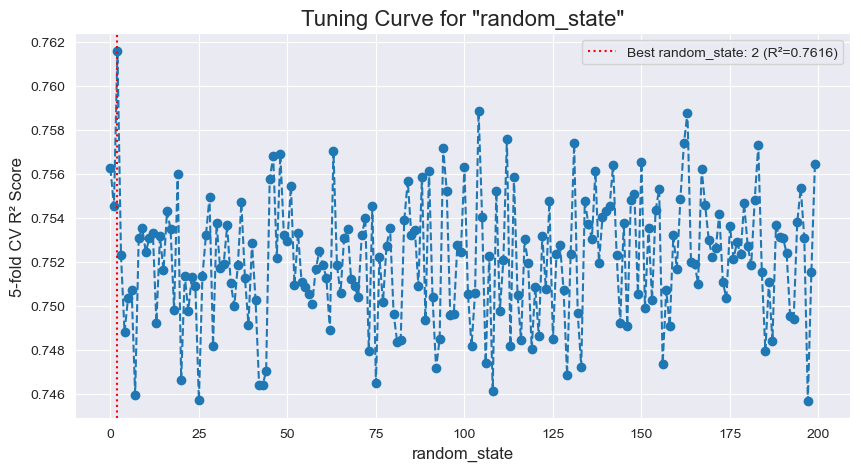

Best model random_state found: 2 with CV R² = 0.7616

--- Tuning: n_estimators ---
Tuning n_estimators over 100 values...


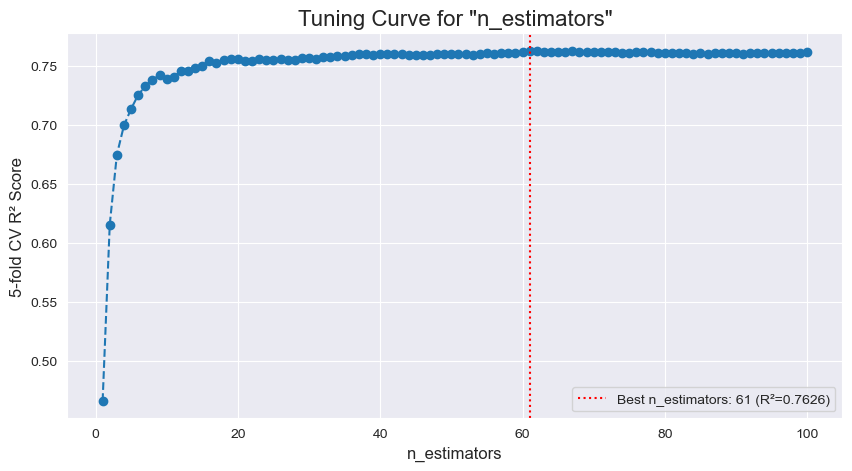

Best n_estimators found: 61 with CV R² = 0.7626

--- Tuning: max_depth ---
Tuning max_depth over 100 values...


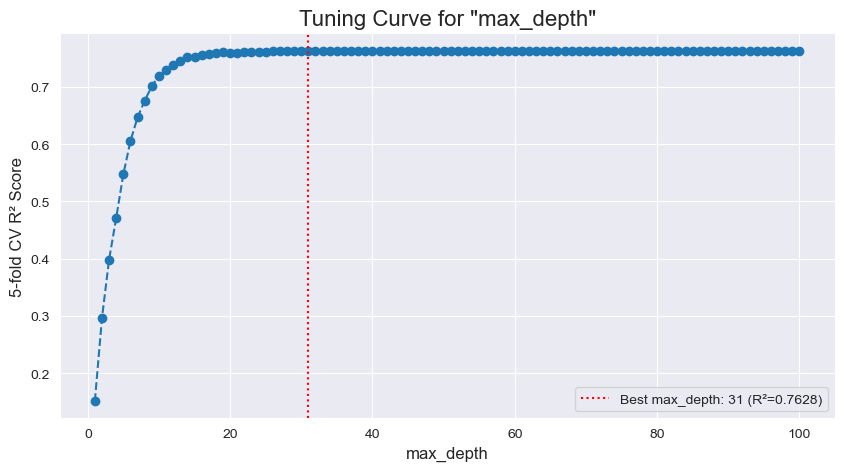

Best max_depth found: 31 with CV R² = 0.7628



In [4]:
def tune_hyperparameter(param_name, param_range, fixed_params, X, y):
    """
    Tunes a single hyperparameter for RandomForestRegressor and visualizes the result.
    """
    scores = []
    print(f"Tuning {param_name} over {len(param_range)} values...")
    for value in param_range:
        params = fixed_params.copy()
        params[param_name] = value
        model = RandomForestRegressor(**params, n_jobs=-1)
        score = cross_val_score(model, X, y, cv=5, scoring='r2').mean()
        scores.append(score)
        
    best_score = max(scores)
    best_value = param_range[np.argmax(scores)]
    
    plt.figure(figsize=(10, 5))
    plt.plot(param_range, scores, marker='o', linestyle='--')
    plt.title(f'Tuning Curve for "{param_name}"', fontsize=16)
    plt.xlabel(param_name, fontsize=12)
    plt.ylabel('5-fold CV R² Score', fontsize=12)
    plt.axvline(best_value, color='r', linestyle=':', label=f'Best {param_name}: {best_value} (R²={best_score:.4f})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_value, best_score, scores

# --- Stage 1: Tune model's random_state ---
print("--- Tuning: model's random_state ---")
best_params = {}
best_rs, best_rs_score, _ = tune_hyperparameter(
    'random_state', range(0, 200), best_params, X_train_scaled, y_train
)
best_params['random_state'] = best_rs
print(f"Best model random_state found: {best_rs} with CV R² = {best_rs_score:.4f}\n")

# --- Stage 2: Tune n_estimators ---
print("--- Tuning: n_estimators ---")
best_n_est, best_n_est_score, _ = tune_hyperparameter(
    'n_estimators', range(1, 101), best_params, X_train_scaled, y_train
)
best_params['n_estimators'] = best_n_est
print(f"Best n_estimators found: {best_n_est} with CV R² = {best_n_est_score:.4f}\n")

# --- Stage 3: Tune max_depth ---
print("--- Tuning: max_depth ---")
best_max_depth, best_max_depth_score, _ = tune_hyperparameter(
    'max_depth', range(1, 101), best_params, X_train_scaled, y_train
)
best_params['max_depth'] = best_max_depth
print(f"Best max_depth found: {best_max_depth} with CV R² = {best_max_depth_score:.4f}\n")

In [5]:
final_rfr = RandomForestRegressor(**best_params, n_jobs=-1)

cv_r2 = cross_val_score(final_rfr, X_train_scaled, y_train, cv=5, scoring='r2').mean()
cv_predictions = cross_val_predict(final_rfr, X_train_scaled, y_train, cv=5)
cv_rmse = np.sqrt(mean_squared_error(y_train, cv_predictions))
cv_mae = mean_absolute_error(y_train, cv_predictions)
final_rfr.fit(X_train_scaled, y_train)
test_predictions = final_rfr.predict(X_test_scaled)
test_r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print("\n" + "="*50)
print("        Final Model Performance Summary")
print("="*50)
print(f"R² (5-fold CV):               {cv_r2:.4f}")
print(f"R² (External Validation):     {test_r2:.4f}")
print("-" * 50)
print(f"RMSE (5-fold CV):             {cv_rmse:.4f}")
print(f"RMSE (External Validation):   {test_rmse:.4f}")
print("-" * 50)
print(f"MAE (5-fold CV):              {cv_mae:.4f}")
print(f"MAE (External Validation):    {test_mae:.4f}")
print("="*50)


        Final Model Performance Summary
R² (5-fold CV):               0.7628
R² (External Validation):     0.7559
--------------------------------------------------
RMSE (5-fold CV):             15.0958
RMSE (External Validation):   14.7067
--------------------------------------------------
MAE (5-fold CV):              10.5072
MAE (External Validation):    9.7921


Decision Tree Regressor

In [6]:
from sklearn.tree import DecisionTreeRegressor 

for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    dtr = DecisionTreeRegressor(random_state=42)
    
    cv_score = cross_val_score(dtr, X_train_scaled, y_train, cv=5).mean()
    
    regressor = dtr.fit(X_train_scaled, y_train)
    score_test = regressor.score(X_test_scaled, y_test)

    if cv_score > 0.6 and score_test > 0.65:
        print(f"  - Found state {i}: CV R² = {cv_score:.4f}, Test R² = {score_test:.4f}")

CHOSEN_SPLIT_STATE = 30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=CHOSEN_SPLIT_STATE)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Data split and scaled. Training set size: {X_train_scaled.shape[0]}, Test set size: {X_test_scaled.shape[0]}")

  - Found state 10: CV R² = 0.6251, Test R² = 0.6506
  - Found state 19: CV R² = 0.6126, Test R² = 0.6717
  - Found state 22: CV R² = 0.6137, Test R² = 0.6517
  - Found state 29: CV R² = 0.6505, Test R² = 0.6764
  - Found state 32: CV R² = 0.6022, Test R² = 0.6590
  - Found state 60: CV R² = 0.6027, Test R² = 0.6512
  - Found state 72: CV R² = 0.6198, Test R² = 0.6668
  - Found state 78: CV R² = 0.6023, Test R² = 0.7163
  - Found state 93: CV R² = 0.6395, Test R² = 0.6731
  - Found state 99: CV R² = 0.6305, Test R² = 0.6985
  - Found state 101: CV R² = 0.6027, Test R² = 0.7204
  - Found state 163: CV R² = 0.6095, Test R² = 0.7167
  - Found state 186: CV R² = 0.6164, Test R² = 0.6931
  - Found state 197: CV R² = 0.6048, Test R² = 0.6510
  - Found state 198: CV R² = 0.6084, Test R² = 0.6790
Data split and scaled. Training set size: 964, Test set size: 242


--- Tuning: model's random_state ---
Tuning random_state over 200 values...


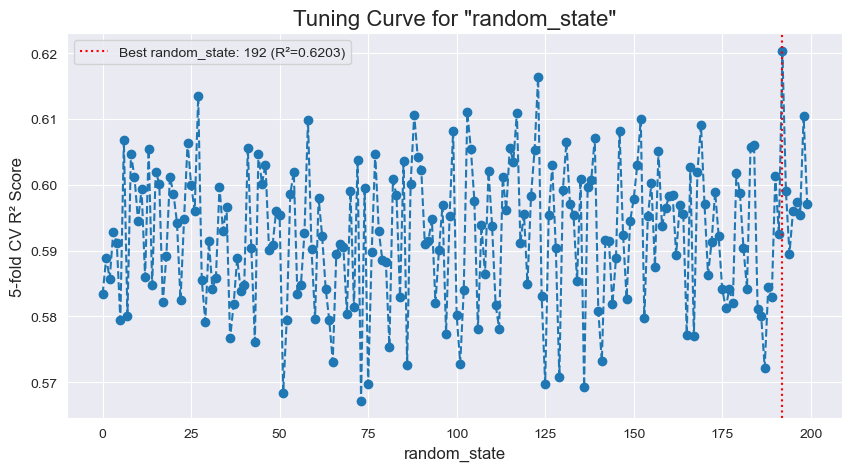

Best model random_state found: 192 with CV R² = 0.6203

Tuning max_depth over 50 values...


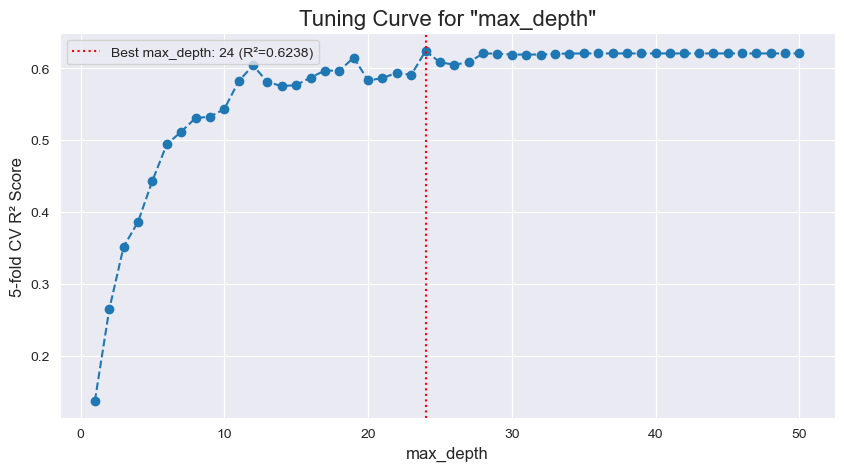

Best max_depth found: 24 with CV R² = 0.6238

Decision Tree hyperparameter tuning complete!
Final best parameters: {'random_state': 192, 'max_depth': 24}
Final best CV score: 0.6238


In [7]:
def tune_dt_hyperparameter(param_name, param_range, fixed_params, X, y):
    scores = []
    print(f"Tuning {param_name} over {len(param_range)} values...")
    for value in param_range:
        params = fixed_params.copy()
        params[param_name] = value
        model = DecisionTreeRegressor(**params) # <-- 核心变化：使用 DecisionTreeRegressor
        score = cross_val_score(model, X, y, cv=5, scoring='r2').mean()
        scores.append(score)
        
    best_score = max(scores)
    best_value = param_range[np.argmax(scores)]
    
    plt.figure(figsize=(10, 5))
    plt.plot(param_range, scores, marker='o', linestyle='--')
    plt.title(f'Tuning Curve for "{param_name}"', fontsize=16)
    plt.xlabel(param_name, fontsize=12)
    plt.ylabel('5-fold CV R² Score', fontsize=12)
    plt.axvline(best_value, color='r', linestyle=':', label=f'Best {param_name}: {best_value} (R²={best_score:.4f})')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_value, best_score

print("--- Tuning: model's random_state ---")
best_params_dt = {}
best_rs_dt, best_rs_score_dt = tune_dt_hyperparameter(
    'random_state', range(0, 200), best_params_dt, X_train_scaled, y_train
)
best_params_dt['random_state'] = best_rs_dt
print(f"Best model random_state found: {best_rs_dt} with CV R² = {best_rs_score_dt:.4f}\n")

best_max_depth_dt, best_max_depth_score_dt = tune_dt_hyperparameter(
    'max_depth', range(1, 51), best_params_dt, X_train_scaled, y_train # 搜索到50即可
)
best_params_dt['max_depth'] = best_max_depth_dt
print(f"Best max_depth found: {best_max_depth_dt} with CV R² = {best_max_depth_score_dt:.4f}\n")

print("="*50)
print("Decision Tree hyperparameter tuning complete!")
print("Final best parameters:", best_params_dt)
print(f"Final best CV score: {best_max_depth_score_dt:.4f}")
print("="*50)

In [8]:
final_dtr = DecisionTreeRegressor(**best_params_dt)

cv_r2 = cross_val_score(final_dtr, X_train_scaled, y_train, cv=5, scoring='r2').mean()
cv_predictions = cross_val_predict(final_dtr, X_train_scaled, y_train, cv=5)
cv_rmse = np.sqrt(mean_squared_error(y_train, cv_predictions))
cv_mae = mean_absolute_error(y_train, cv_predictions)

final_dtr.fit(X_train_scaled, y_train)
test_predictions = final_dtr.predict(X_test_scaled)
test_r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print("\n" + "="*50)
print("     Decision Tree Final Model Performance Summary")
print("="*50)
print(f"R² (5-fold CV):               {cv_r2:.4f}")
print(f"R² (External Validation):     {test_r2:.4f}")
print("-" * 50)
print(f"RMSE (5-fold CV):             {cv_rmse:.4f}")
print(f"RMSE (External Validation):   {test_rmse:.4f}")
print("-" * 50)
print(f"MAE (5-fold CV):              {cv_mae:.4f}")
print(f"MAE (External Validation):    {test_mae:.4f}")
print("="*50)


     Decision Tree Final Model Performance Summary
R² (5-fold CV):               0.6238
R² (External Validation):     0.7562
--------------------------------------------------
RMSE (5-fold CV):             18.5494
RMSE (External Validation):   15.8275
--------------------------------------------------
MAE (5-fold CV):              12.3862
MAE (External Validation):    10.5063


SVM

In [9]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from itertools import product

def tune_model(model_class, param_grid, X_train, y_train):
    best_r2, best_model_params = -np.inf, None
    cv = KFold(n_splits=5, shuffle=True, random_state=40)
    param_values = list(param_grid.values())
    for params_tuple in product(*param_values):
        current_params = dict(zip(param_grid.keys(), params_tuple))
        model = model_class(**current_params)
        cv_pred = cross_val_predict(model, X_train, y_train, cv=cv)
        cv_r2   = r2_score(y_train, cv_pred)
        if cv_r2 > best_r2:
            best_r2, best_model_params = cv_r2, current_params

    print(f"Best CV R²: {best_r2:.4f}")
    print(f"Best parameters: {best_model_params}")
    best_model = model_class(**best_model_params)
    best_model.fit(X_train, y_train)
    return best_model

def evaluate_model(model, X_train, y_train, X_test, y_test):
    cv = KFold(n_splits=5, shuffle=True, random_state=40)
    cv_pred  = cross_val_predict(model, X_train, y_train, cv=cv)
    test_pred = model.predict(X_test)
    def metrics(y_true, y_hat):
        return (r2_score(y_true, y_hat),
                np.sqrt(mean_squared_error(y_true, y_hat)),
                mean_absolute_error(y_true, y_hat))
    r2_cv, rmse_cv, mae_cv = metrics(y_train, cv_pred)
    r2_te, rmse_te, mae_te = metrics(y_test, test_pred)
    print(f'R²={r2_cv:.3f}, RMSE={rmse_cv:.2f}, MAE={mae_cv:.2f}')
    print(f'R²={r2_te:.3f}, RMSE={rmse_te:.2f}, MAE={mae_te:.2f}')

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=40)
scaler = StandardScaler().fit(Xtr)
Xtr_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xte)

gbr_param_grid = {
    'n_estimators':  [300, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth':     [3, 4],
    'random_state':  [40]
}
best_gbr_model = tune_model(GradientBoostingRegressor, gbr_param_grid, Xtr_s, ytr)
print("\n--- Final GBR Model Evaluation ---")
evaluate_model(best_gbr_model, Xtr_s, ytr, Xte_s, yte)

# ---------- 4. 为 SVM 定义参数网格并执行 ----------
svm_param_grid = {
    'kernel': ['rbf'],
    'C':      [1, 10, 100],
    'gamma':  ['scale', 0.1, 0.01]
}
best_svm_model = tune_model(SVR, svm_param_grid, Xtr_s, ytr)
print("\n--- Final SVM Model Evaluation ---")
evaluate_model(best_svm_model, Xtr_s, ytr, Xte_s, yte)

Best CV R²: 0.7582
Best parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'max_depth': 4, 'random_state': 40}

--- Final GBR Model Evaluation ---
R²=0.758, RMSE=15.09, MAE=9.69
R²=0.865, RMSE=11.44, MAE=7.89
Best CV R²: 0.3150
Best parameters: {'kernel': 'rbf', 'C': 100, 'gamma': 'scale'}

--- Final SVM Model Evaluation ---
R²=0.315, RMSE=25.40, MAE=18.01
R²=0.430, RMSE=23.49, MAE=15.87
